In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install --upgrade setuptools pip
!pip install "numpy>=1.24"
!pip install d2l --no-deps
!pip install matplotlib pandas requests

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 41.0 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 75.2.0
    Uninstalling setuptools-75.2.0:
      Successfully uninstalled setuptools-75.2.0
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.26.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
bigframes 2.26.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
fastai 2.8.4 requires fastcore<1.9,>=1.8.0, but you have fastcore 1.11.3 which is incompatible.


In [3]:
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
from d2l import torch as d2l

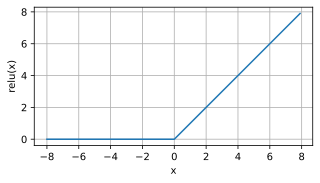

In [4]:
# Activation function 
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.relu(x)
d2l.plot(x.detach(), y.detach(), 'x', 'relu(x)', figsize=(5, 2.5))

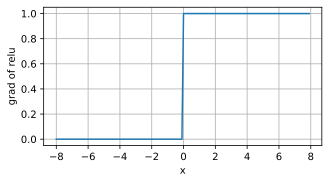

In [5]:
# Sigmoid Function
y.backward(torch.ones_like(x), retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of relu', figsize=(5, 2.5))

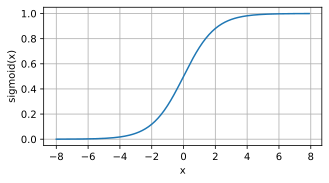

In [6]:
y = torch.sigmoid(x)
d2l.plot(x.detach(), y.detach(), 'x', 'sigmoid(x)', figsize=(5, 2.5))

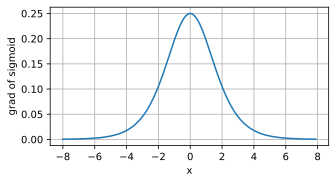

In [7]:
# Clear out previous gradients
x.grad.data.zero_()
y.backward(torch.ones_like(x),retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of sigmoid', figsize=(5, 2.5))

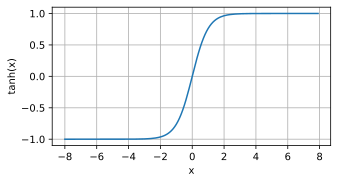

In [8]:
# Tanh Function
y = torch.tanh(x)
d2l.plot(x.detach(), y.detach(), 'x', 'tanh(x)', figsize=(5, 2.5))

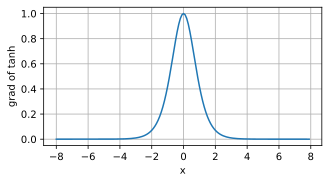

In [9]:
# Clear out previous gradients
x.grad.data.zero_()
y.backward(torch.ones_like(x),retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of tanh', figsize=(5, 2.5))

## Demo test with MNIST

### Multi layer perceptrons from scratches 

Recall that Fashion-MNIST contains 10 classes, and that each image consists of a 28 ×
28 = 784 grid of grayscale pixel values. 

In [10]:
import torch
from torch import nn
from d2l import torch as d2l

In [11]:
class MLPScratch(d2l.Classifier):
    def __init__(self, num_inputs, num_outputs, num_hiddens, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.W1 = nn.Parameter(torch.randn(num_inputs, num_hiddens) * sigma)
        self.b1 = nn.Parameter(torch.zeros(num_hiddens))
        self.W2 = nn.Parameter(torch.randn(num_hiddens, num_outputs) * sigma)
        self.b2 = nn.Parameter(torch.zeros(num_outputs))

In [12]:
# Model
def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X, a)

In [13]:
@d2l.add_to_class(MLPScratch)
def forward(self, X):
    X = X.reshape((-1, self.num_inputs))
    H = relu(torch.matmul(X, self.W1) + self.b1)
    return torch.matmul(H, self.W2) + self.b2

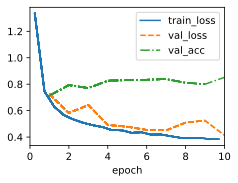

In [14]:
# Training
model = MLPScratch(num_inputs=784, num_outputs=10, num_hiddens=256, lr=0.1)
data = d2l.FashionMNIST(batch_size=256)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

In [15]:
# other Model
class MLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(nn.Flatten(), nn.LazyLinear(num_hiddens), nn.ReLU(), nn.LazyLinear(num_outputs))

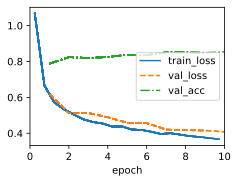

In [16]:
# Training
model = MLP(num_outputs=10, num_hiddens=256, lr=0.1)
trainer.fit(model, data)

## Computational Graph for Forward Propagation

In [17]:
!pip install torchviz

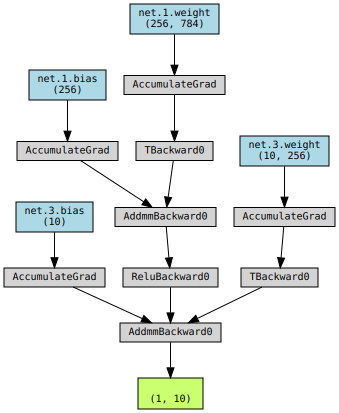

In [18]:
import torch
from torchviz import make_dot

# 1. Initialize
model = MLP(num_outputs=10, num_hiddens=256, lr=0.1)

# 2. THE FIX: Perform a dummy forward pass
# Match the shape of your expected input (e.g., [Batch, Channels, Height, Width])
dummy_input = torch.randn(1, 1, 28, 28) 
output = model(dummy_input) 

# 3. Now visualize
# We pass the output 'output' so torchviz can trace the grad_fn back to the inputs
dot = make_dot(output, params=dict(list(model.named_parameters())))

# 4. Save and view
dot.render("mlp_graph", format="png")
dot # This will display it if you are in a Jupyter Notebook

## Vanishing Gradients

One frequent culprit causing the vanishing gradient problem is the choice of the activation
function 𝜎 that is appended following each layer’s linear operations. Historically, the sig-
moid function 1/(1+exp(−𝑥)) (introduced in Section 5.1) was popular because it resembles
a thresholding function. Since early artificial neural networks were inspired by biological
neural networks, the idea of neurons that fire either fully or not at all (like biological neu-
rons) seemed appealing. Let’s take a closer look at the sigmoid to see why it can cause
vanishing gradients.

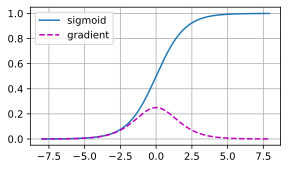

In [19]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.sigmoid(x)
y.backward(torch.ones_like(x))
d2l.plot(x.detach().numpy(), [y.detach().numpy(), x.grad.numpy()], legend=['sigmoid', 'gradient'], figsize=(4.5, 2.5))

## Exploding Gradients

The opposite problem, when gradients explode, can be similarly vexing. To illustrate this
a bit better, we draw 100 Gaussian random matrices and multiply them with some initial
matrix. For the scale that we picked (the choice of the variance 𝜎2 = 1), the matrix product
explodes. When this happens because of the initialization of a deep network, we have no
chance of getting a gradient descent optimizer to converge.

In [20]:
M = torch.normal(0, 1, size=(4, 4))
print('a single matrix \n',M)

for i in range(100):
    M = M @ torch.normal(0, 1, size=(4, 4))
    print('after multiplying 100 matrices\n', M)

a single matrix 
 tensor([[-1.1061,  0.2858, -1.0921,  0.3489],
        [ 1.1680, -1.1789, -0.3359,  0.3254],
        [ 0.1919, -0.3539,  0.8021, -0.2779],
        [ 0.6360, -0.1970, -0.8089,  0.4386]])
after multiplying 100 matrices
 tensor([[-2.2722, -2.2202,  1.6348, -1.0224],
        [-0.3062,  1.0881,  1.7089, -1.4334],
        [ 0.3514,  0.9508, -0.9679,  0.6037],
        [ 0.1231, -0.0178,  1.5196, -1.1189]])
after multiplying 100 matrices
 tensor([[ 2.9731, -3.1106, -4.4300,  0.7464],
        [ 0.2347, -0.6270, -3.9284, -0.4219],
        [-1.2741,  1.1847,  1.7856,  0.7099],
        [ 0.8069, -0.8323, -2.7172, -1.3426]])
after multiplying 100 matrices
 tensor([[ 6.8442, -0.4935,  5.5761, -7.3096],
        [ 2.1072,  3.9060,  0.9258, -5.0006],
        [-1.6428, -1.3597, -2.3045,  3.6083],
        [ 0.9313,  3.7103,  1.6315, -4.6469]])
after multiplying 100 matrices
 tensor([[-21.5644,   4.9026,  -2.1771,  -3.9977],
        [ -8.9574,  -1.3472,  -2.4685,  -2.5395],
        [  7.7

## Dropout in Practice

When we apply dropout to a hidden layer, zeroing out each hidden unit with probability 𝑝, the result can
be viewed as a network containing only a subset of the original neurons. In Fig. 5.6.1, ℎ2
and ℎ5 are removed. Consequently, the calculation of the outputs no longer depends on ℎ2
or ℎ5 and their respective gradient also vanishes when performing backpropagation. In this
way, the calculation of the output layer cannot be overly dependent on any one element of
ℎ1, . . . , ℎ5

In [21]:
def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    if dropout == 1: return torch.zeros_like(X)
    mask = (torch.rand(X.shape) > dropout).float()
    return mask * X / (1.0 - dropout)

In [22]:
X = torch.arange(16, dtype = torch.float32).reshape((2, 8))
print('dropout_p = 0:', dropout_layer(X, 0))
print('dropout_p = 0.5:', dropout_layer(X, 0.5))
print('dropout_p = 1:', dropout_layer(X, 1))

dropout_p = 0: tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
dropout_p = 0.5: tensor([[ 0.,  0.,  0.,  6.,  0.,  0.,  0., 14.],
        [ 0.,  0.,  0., 22.,  0.,  0.,  0., 30.]])
dropout_p = 1: tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])


In [23]:
# Defining the model
class DropoutMLPScratch(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens_1, num_hiddens_2,
        dropout_1, dropout_2, lr):
        super().__init__()
        self.save_hyperparameters()
        self.lin1 = nn.LazyLinear(num_hiddens_1)
        self.lin2 = nn.LazyLinear(num_hiddens_2)
        self.lin3 = nn.LazyLinear(num_outputs)
        self.relu = nn.ReLU()
        
    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((X.shape[0], -1))))
        if self.training:
            H1 = dropout_layer(H1, self.dropout_1)
            
        H2 = self.relu(self.lin2(H1))
        if self.training:
            H2 = dropout_layer(H2, self.dropout_2)
        return self.lin3(H2)

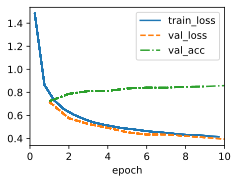

In [24]:
# Training
hparams = {'num_outputs':10, 'num_hiddens_1':256, 'num_hiddens_2':256,
'dropout_1':0.5, 'dropout_2':0.5, 'lr':0.1}
model = DropoutMLPScratch(**hparams)
data = d2l.FashionMNIST(batch_size=256)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

In [25]:
# Concise Implementation
class DropoutMLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens_1, num_hiddens_2,
        dropout_1, dropout_2, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(
        nn.Flatten(), nn.LazyLinear(num_hiddens_1), nn.ReLU(),
        nn.Dropout(dropout_1), nn.LazyLinear(num_hiddens_2), nn.ReLU(),
        nn.Dropout(dropout_2), nn.LazyLinear(num_outputs))

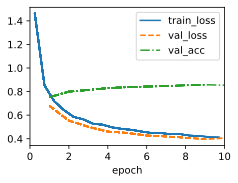

In [26]:
# Training
model = DropoutMLP(**hparams)
trainer.fit(model, data)